offset: 4 4 peak: 0.7299155844787165 classified letter: Z


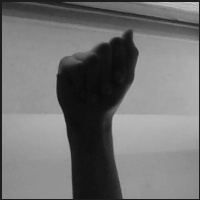

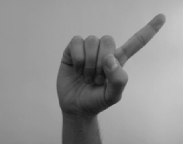

----------------------------------
offset: 41 14 peak: 0.3757494756020351 classified letter: J


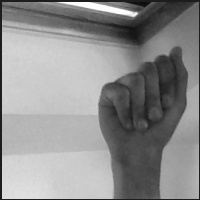

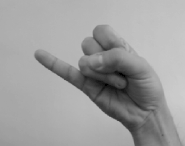

----------------------------------
offset: 48 14 peak: 0.6495070613789394 classified letter: S


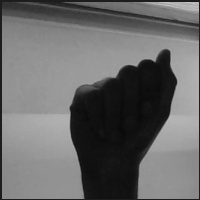

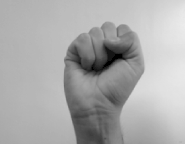

----------------------------------
offset: 24 14 peak: 0.34749530542952056 classified letter: S


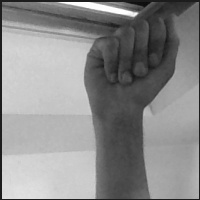

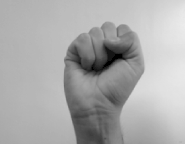

----------------------------------
offset: 38 12 peak: 0.5925333204082963 classified letter: E


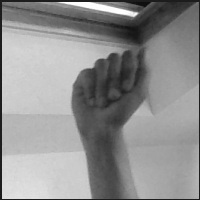

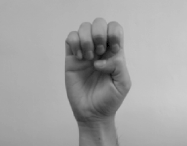

----------------------------------
offset: 47 0 peak: 0.28547997748570403 classified letter: N


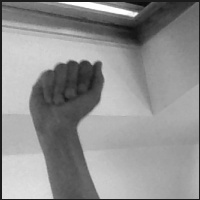

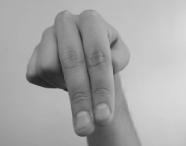

----------------------------------
offset: 55 10 peak: 0.622911034140565 classified letter: Z


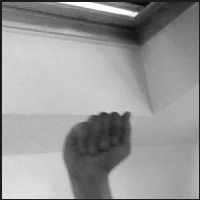

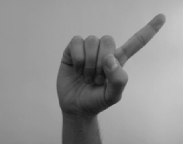

----------------------------------
offset: 53 0 peak: 0.2786820556424855 classified letter: N


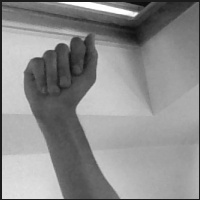

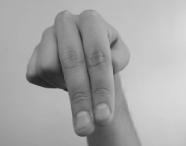

----------------------------------
offset: 42 14 peak: 0.41010904048880864 classified letter: J


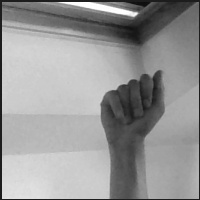

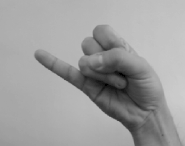

----------------------------------
offset: 51 12 peak: 0.6662415827578183 classified letter: E


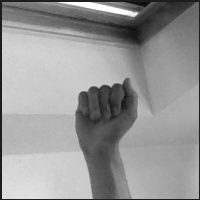

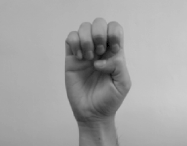

----------------------------------
offset: 2 0 peak: 0.14940907726913705 classified letter: C


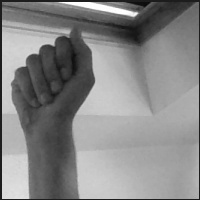

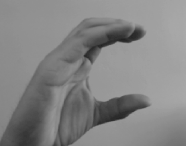

----------------------------------
offset: 38 2 peak: 0.5621854476292887 classified letter: E


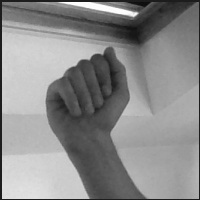

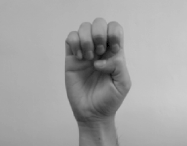

----------------------------------
offset: 55 0 peak: 0.334679713436016 classified letter: Z


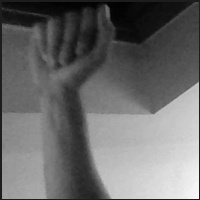

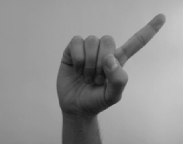

----------------------------------
offset: 55 7 peak: 0.577501770738019 classified letter: Z


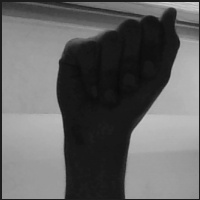

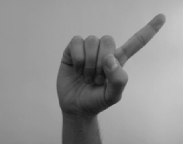

----------------------------------
offset: 55 13 peak: 0.5863280821456134 classified letter: Z


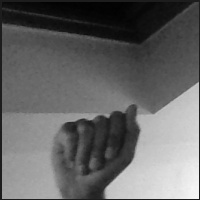

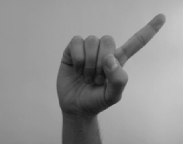

----------------------------------
offset: 55 14 peak: 0.11666423215821907 classified letter: S


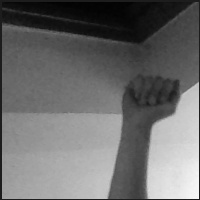

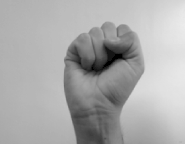

----------------------------------
offset: 54 0 peak: 0.43383388364992004 classified letter: R


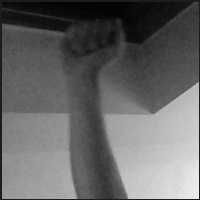

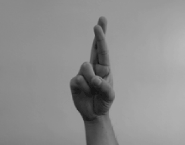

----------------------------------
offset: 43 16 peak: 0.5266103965634892 classified letter: Z


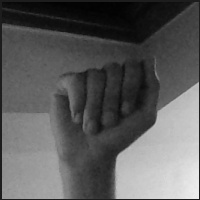

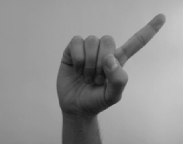

----------------------------------
offset: 52 0 peak: 0.4460057906707129 classified letter: L


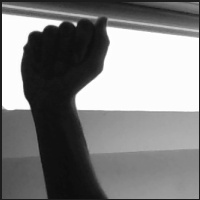

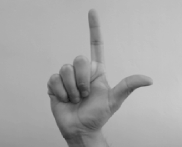

----------------------------------
offset: 34 0 peak: 0.591864430253178 classified letter: N


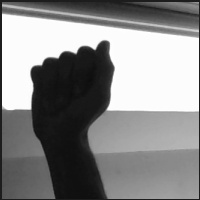

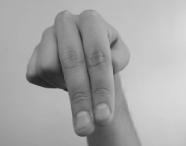

----------------------------------
offset: 32 11 peak: 0.7333058214007828 classified letter: S


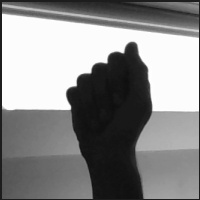

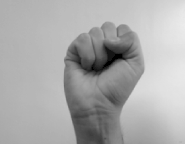

----------------------------------
offset: 15 6 peak: 0.5816430772435203 classified letter: S


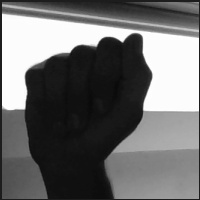

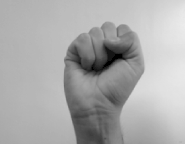

----------------------------------
offset: 16 13 peak: 0.4860596928410314 classified letter: N


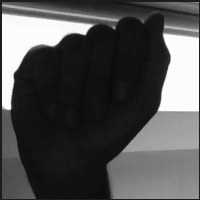

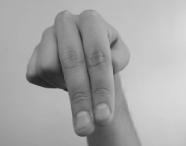

----------------------------------
offset: 32 5 peak: 0.7768633653628767 classified letter: Z


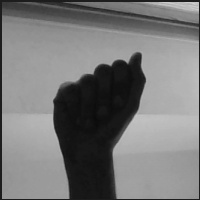

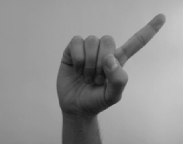

----------------------------------
offset: 34 13 peak: 0.7171902435270174 classified letter: A


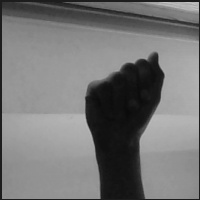

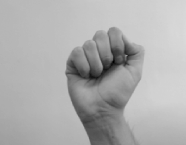

----------------------------------
offset: 54 13 peak: 0.33875452397020583 classified letter: A


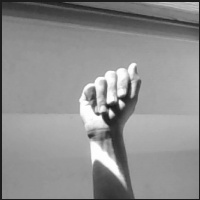

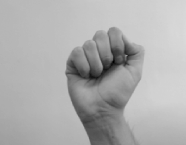

----------------------------------
offset: 38 14 peak: 0.16670870477870933 classified letter: J


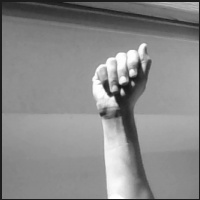

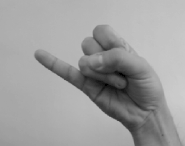

----------------------------------
offset: 16 0 peak: 0.5486216019736919 classified letter: Z


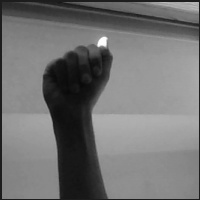

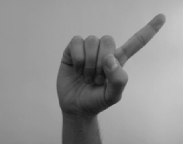

----------------------------------
offset: 20 0 peak: 0.38867164160728745 classified letter: N


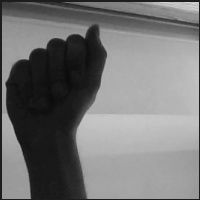

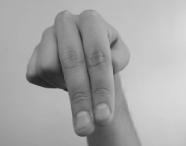

----------------------------------
offset: 53 13 peak: 0.5025626489275176 classified letter: N


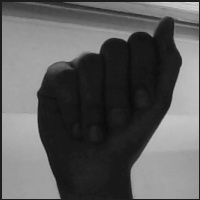

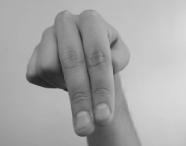

----------------------------------
2 / 30
Accuracy of target images A is: %6.666666666666667


In [40]:
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow

def readNlist(location):
  # Get all file names in folder, read them as an image
  folder = os.listdir(location)
  folder.sort()

  img_list = []

  for name in folder:
    if name[0] != ".":
      img = cv2.imread(location + name, 0)
      img_list.append(img)

  return img_list


def NCC(img1, img2):
  # Subtract means from intensities
  img1 = img1 - img1.mean()  
  img2 = img2 - img2.mean()
  # Normalize values
  normImg1 = img1 / np.linalg.norm(img1)
  normImg2 = img2 / np.linalg.norm(img2)
  # Calculate NCC
  return np.sum(normImg1 * normImg2) / np.sqrt(np.sum(normImg1**2) * np.sum(normImg2**2))


def find_peak_offset(template, target, idx):
  # Find peak and offset values for one template over one target
  templateRow, templateCol = template.shape
  offset_u, offset_v, peak = 0, 0, 0

  # Slide template over target image
  for r in range(targetRow - templateRow):
    for c in range(targetCol - templateCol):
      # Crop overlapping part from target (sizes must be equal to calculate NCC)
      target_part = target[r : r + templateRow, c : c + templateCol]

      ncc = NCC(target_part, template)  # Calculate Normalized Cross Correlation
      if ncc > peak:
        # Find highest peak NCC value and its offset values
        offset_u, offset_v, peak = r, c, ncc
  
  return offset_u, offset_v, peak


# ------------------------------ MAIN ------------------------------

# Change according to the folder's name which you want to work on
# I run target folders seperately by their corresponding letters
target_name = "A"

# Template folder location
template_folder_location = "/content/sample_data/template/"
target_folder_location = "/content/sample_data/" + target_name + "/"

# Real index of currently executed letter
real_index = ord(target_name) - ord("A")  # target_name must be a char

# Get all target and template images in lists
template_list = readNlist(template_folder_location)
target_list = readNlist(target_folder_location)


all_results = []
true_classification = 0  # number of correct classifications

# Loop through every target image in target_list
for target in target_list:

  targetRow, targetCol = target.shape
  sub_results = []
  result_offset_u, result_offset_v, result_peak, result_index = 0, 0, 0, 0
  idx = 0

  # Loop through every template image in template_list for target image classification
  for template in template_list:
    # Calculate peak and offset values with function
    offset_u, offset_v, peak = find_peak_offset(template, target, idx)

    if peak > result_peak:
      # Find highest peak NCC value and its offset values through all template images
      result_offset_u, result_offset_v, result_peak, result_index = offset_u, offset_v, peak, idx
    
    sub_results.append(peak)
    idx += 1

  # Add target-template match to all_results list
  all_results.append((result_offset_u, result_offset_v, result_peak, result_index))  

  print("offset:", result_offset_u, result_offset_v, "peak:",
        result_peak, "classified letter:", chr(result_index + ord("A")))
  
  # Google Colab cv2.imshow() method
  cv2_imshow(target)
  cv2_imshow(template_list[result_index])

  print("----------------------------------")

  # If classification is correct (target index == found template index)
  if result_index == real_index:
    true_classification += 1

# Calculate accuracy. Since there is no True Negative, accuracy = True Positive / All
# (All target images are same letter. So if correct, it's True Positive; if wrong, it's False Positive) 
accuracy = (true_classification / len(target_list)) * 100
print(str(true_classification) + " / " + str(len(target_list)))

print("Accuracy of target images " + chr(ord("A") + real_index) + " is: %" + str(accuracy))
